In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pymc as pm
from numba import njit
import pytensor.tensor as pt
import arviz as az
from pytensor.compile.ops import as_op
import logging
import os
from plotting import *
import sys
import os
import sys

# Go 3 levels up from current working directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

# Now you can import from the project
from utils import plot_trace, plot_convergence, plot_posterior_pairs, posterior_dynamics2


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:

## differential equation and solvers

def logistic_growth_death(y, t, params):
    # Use indexing instead of unpacking
    P = y[0]
    D = y[1]
    r = params[0]
    K = params[1]
    delta = params[2]

    dydt = [0, 0]
    dydt[0] = r * (1 - P / K) * P - delta * P
    dydt[1] = delta * P
    return dydt


In [3]:
# load data
dataset = pd.read_csv("./../data/total_cells.csv")

ehux_d7_cells  = dataset.head(15)
ehux_cells = dataset.tail(15)

ehux_total_time = ehux_cells['Time (days)'].values
ehux_total_density = 1e6*ehux_cells[' Density (1e6/ml)'].values
ehux_d7_total_time = ehux_d7_cells['Time (days)'].values
ehux_d7_total_density = 1e6*ehux_d7_cells[' Density (1e6/ml)'].values

In [4]:
# load data
death_dataset = pd.read_csv("./../data/death_percentage.csv")

ehux_death = death_dataset.head(15)
ehux_d7_death = death_dataset.tail(15)

ehux_dead_time = ehux_death['Time (days)']
ehux_dead_density = ehux_death[' Dead percentage '].values*ehux_total_density/100
ehux_d7_dead_time = ehux_d7_death['Time (days)']
ehux_d7_dead_density = ehux_d7_death[' Dead percentage ']*ehux_d7_total_density/100


In [5]:
ehux_dead_density

array([  29286.89616957,   57599.23564723,  131788.32093464,
        170998.48854448,  247888.75433767,  286700.48256887,
        317227.16288447,  559413.03510718,  793253.2021933 ,
       1528245.16356617, 2043617.75950245, 2250742.61477148,
       2788937.45354851, 3187679.81254406, 3157432.34420954])

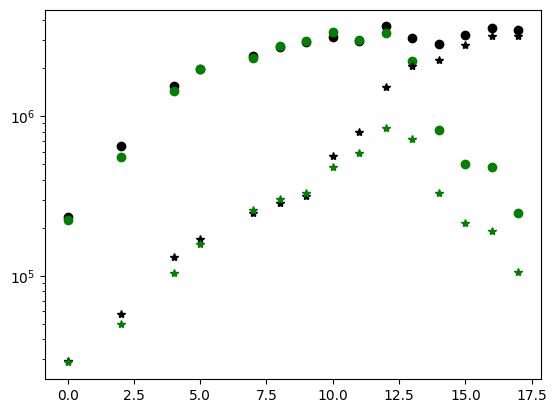

In [6]:
plt.plot(ehux_total_time, ehux_total_density,'ko')
plt.plot(ehux_d7_total_time, ehux_d7_total_density,'go')
plt.plot(ehux_dead_time, ehux_dead_density,'k*')
plt.plot(ehux_d7_dead_time, ehux_d7_dead_density,'g*')
plt.yscale('log')


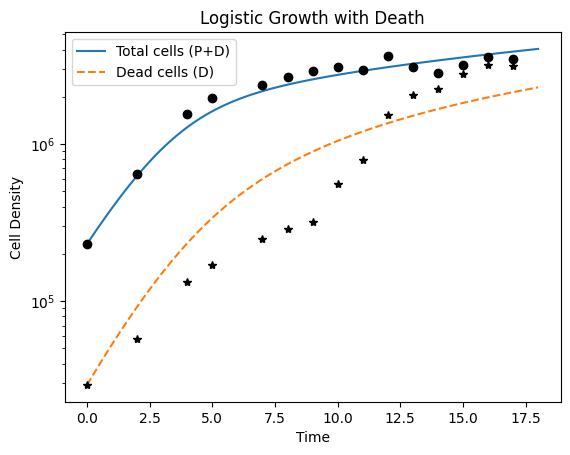

In [9]:
r_guess = 0.7
K_guess =2e6
delta_guess = 0.09
y0_guess = [ehux_total_density[0] - ehux_dead_density[0],ehux_dead_density[0]]
params_guess = (r_guess, K_guess, delta_guess)
#initial conditions
t = np.linspace(0, 18, 100)

def solved_num_cells(y0,t,params):
    sol = odeint(logistic_growth_death, y0, t, args=(params,))
    return sol
    
     

# Solve ODE
solution = solved_num_cells(y0_guess, t, params_guess)

# Optional: Plot results
plt.plot(t, solution[:, 0]+solution[:, 1],'-', label='Total cells (P+D)')
plt.plot(t, solution[:, 1], '--',label='Dead cells (D)')
plt.plot(ehux_total_time, ehux_total_density,'ko')
plt.plot(ehux_dead_time, ehux_dead_density,'k*')
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Cell Density')
plt.legend()
plt.title('Logistic Growth with Death')
plt.show()

In [10]:
# Build and return a PyMC model
def build_pymc_model(ehux_total_time, ehux_total_density,ehux_dead_time, ehux_dead_density ):

    # using one solver as both variables have the same time axis.
    cell_model = pm.ode.DifferentialEquation(
        func=logistic_growth_death,
        times=ehux_total_time,
        n_states=2,
        n_theta=3, # because rest goes in y0 
        t0=0
    )

    with pm.Model() as model:
        # Priors
        r = pm.Uniform(r"$r$ (growth rate)", lower=0.5, upper=1)
        K = pm.Uniform(r"$K$ (carrying capacity)" , lower=1e6, upper=4e7)
        delta = pm.Uniform(r"$\delta$ (death rate)", lower=0.01, upper=0.15)
        P0 = pm.Uniform(r"$P_0$ (init. live)", lower=1e5, upper=3e5)
        D0 = pm.Uniform(r"$D_0$ (init. dead)", lower=2e4, upper=4e4)

        sigma_live = pm.HalfNormal(r"$\sigma_L$", 3)
        sigma_dead = pm.HalfNormal(r"$\sigma_D$", 3)

        # Solve the ODE system
        y_hat = cell_model(y0=[P0,D0], theta=[r,K,delta])
        live_solution = y_hat[:,0]
        dead_solution = y_hat[:,1]
        total_solution = live_solution + dead_solution

        # Log likelihoods
        #### I need to clip the values to avoid log(0) ####
        #total_data = pm.Data("total_cells", np.log(data[['rep1', 'rep2', 'rep3']].mean(axis=1).values)) 
        #dead_data = pm.Data("dead_cells", np.log(death_data[['rep1', 'rep2', 'rep3']].mean(axis=1).values)) 
        
        pm.Normal("Y_live", mu=pm.math.log(pm.math.clip(total_solution, 1e-8, np.inf)),sigma=sigma_live,
                observed =  np.log(ehux_total_density))

        pm.Normal("Y_dead", mu=pm.math.log(pm.math.clip(dead_solution, 1e-8, np.inf)),sigma=sigma_dead,
                observed=np.log(ehux_dead_density))

    return model    

In [11]:
def run_inference(model, draws=500, tune=500, chains=4, cores = 4):
    with model:
        trace = pm.sample(draws=draws, tune=tune, chains=chains, return_inferencedata=True, target_accept=0.95, cores = cores)
        #pm.set_data({"total_cells": total_data, "dead_cells": dead_data})
        #posterior_predictive = pm.sample_posterior_predictive(trace)
    
    return trace


In [12]:
model = build_pymc_model(ehux_total_time, ehux_total_density,ehux_dead_time, ehux_dead_density)

In [13]:
trace = run_inference(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$r$ (growth rate), $K$ (carrying capacity), $\delta$ (death rate), $P_0$ (init. live), $D_0$ (init. dead), $\sigma_L$, $\sigma_D$]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 334 seconds.


Sampling: [$D_0$ (init. dead), $K$ (carrying capacity), $P_0$ (init. live), $\delta$ (death rate), $\sigma_D$, $\sigma_L$, $r$ (growth rate), Y_dead, Y_live]


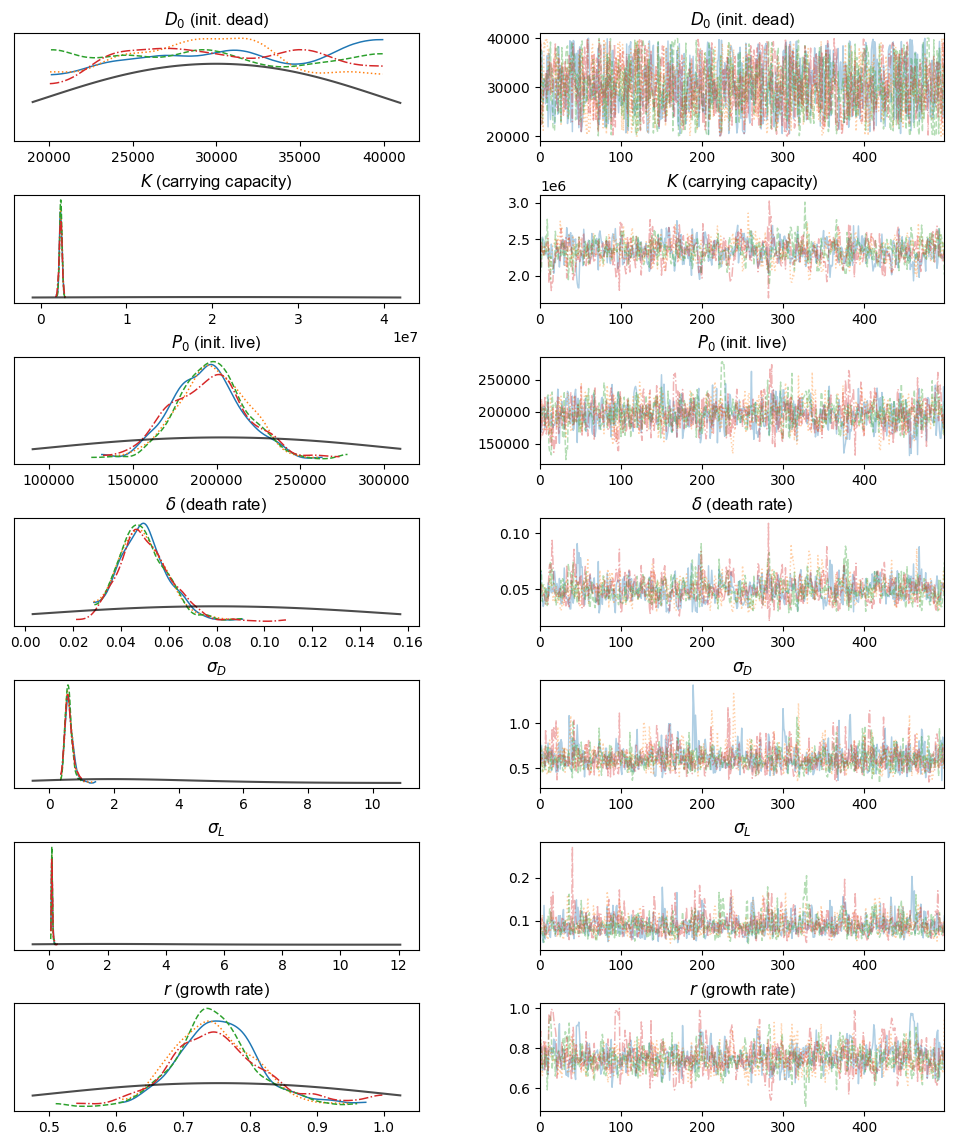

In [15]:
 plot_trace(
    trace=trace,
    model=model,
    #var_names_map={'N0':'Initial density/ml','mum': 'Growth Rate μ', 'sigma': 'Std Dev σ'},
    #var_order=['mum','N0','sigma'],
    fontname='Arial',
    fontsize=12,
    num_prior_samples=2000
    #save_path='../figures/normal_growth_chains.png'
    )
    

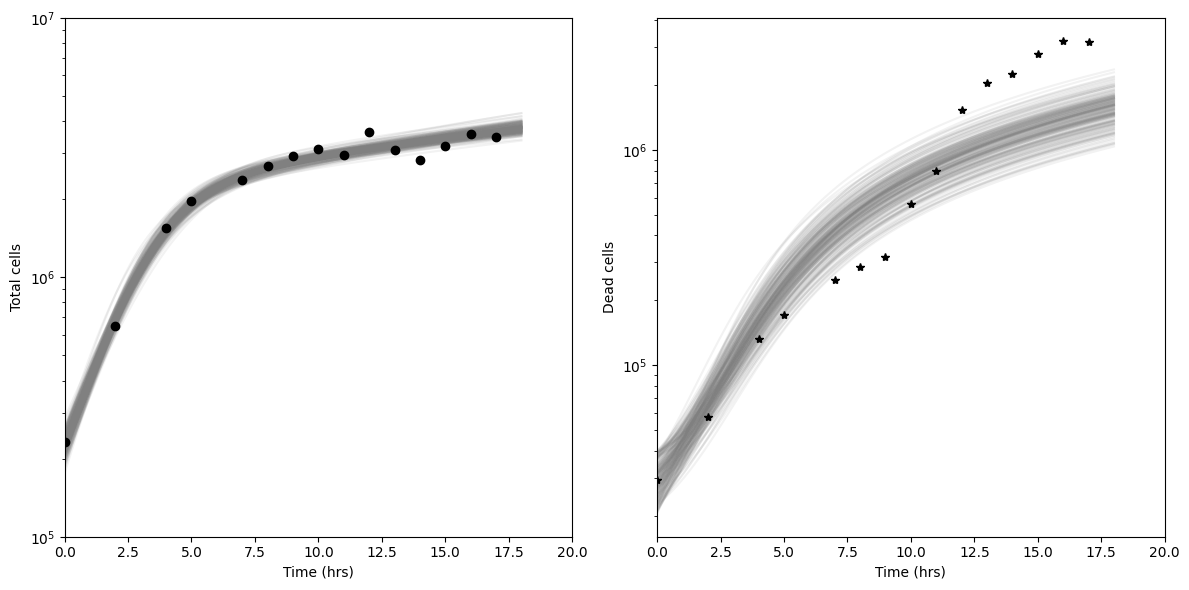

In [17]:
posterior_samples = trace.posterior.stack(draws=("chain", "draw"))
posterior_array = np.vstack([
    posterior_samples["$r$ (growth rate)"].values,
    posterior_samples["$K$ (carrying capacity)"].values,
    posterior_samples["$\delta$ (death rate)"].values,
    posterior_samples["$P_0$ (init. live)"].values,
    posterior_samples["$D_0$ (init. dead)"].values
]).T  # Shape: (n_samples, 5)

n_plot = 200  # Number of samples to simulate for plotting

plt.figure(figsize=(12, 6))

for i in range(n_plot):
    theta = posterior_array[i]
    # last two are initial conditions
    y0 = [theta[-2], theta[-1]]
    time_finer = np.linspace(0, 18, 100)
    sol = odeint(logistic_growth_death, y0, t=time_finer, args=(theta[:-2],), rtol=1e-6, atol=1e-6)
    live = sol[:, 0]
    dead = sol[:, 1]
    total = live + dead

    plt.subplot(1, 2, 1)
    plt.plot(time_finer, total, '-', color='gray', alpha=0.1)

    plt.subplot(1, 2, 2)
    plt.plot(time_finer, dead, '-', color='gray', alpha=0.1)

# Add data points on top
plt.subplot(1, 2, 1)
plt.plot(ehux_total_time, ehux_total_density,'ko')
plt.xlabel('Time (hrs)')
plt.ylabel('Total cells')
plt.yscale('log')
plt.ylim(1e5, 1e7)
plt.xlim(0, 20)

plt.subplot(1, 2, 2)
plt.plot(ehux_dead_time, ehux_dead_density,'k*')
#plt.xlabel(death_data.columns[0])
plt.xlabel('Time (hrs)')
plt.ylabel('Dead cells')
plt.yscale('log')
plt.xlim(0, 20)

plt.tight_layout()
plt.show()


In [62]:
vars_list = list(model.values_to_rvs.keys())[:-1]

In [69]:
posterior_samples = trace.posterior.stack(draws=("chain", "draw"))
posterior_array = np.vstack([
        posterior_samples["$r$ (growth rate)"].values,
        posterior_samples["$K$ (carrying capacity)"].values,
        posterior_samples["$\delta$ (death rate)"].values,
        posterior_samples["$P_0$ (init. live)"].values,
        posterior_samples["$D_0$ (init. dead)"].values
    ]).T  # Shape: (n_samples, 5)

In [71]:
posterior_array

array([[8.17773554e-01, 2.18836781e+06, 5.63029120e-02, 1.79262953e+05,
        3.00626850e+04],
       [7.68530346e-01, 2.10799094e+06, 6.62083295e-02, 2.03362545e+05,
        2.74852779e+04],
       [8.08221973e-01, 2.35043736e+06, 4.40468754e-02, 1.67818851e+05,
        3.74280710e+04],
       ...,
       [7.90653485e-01, 2.18251933e+06, 5.36010162e-02, 1.81496455e+05,
        3.84079923e+04],
       [7.33398627e-01, 2.28007011e+06, 5.46348435e-02, 1.96829935e+05,
        3.92227997e+04],
       [8.13991531e-01, 2.33440444e+06, 5.00743024e-02, 1.65512850e+05,
        2.76469592e+04]])

In [64]:
vars_list

[$r$ (growth rate)_interval__,
 $K$ (carrying capacity)_interval__,
 $\delta$ (death rate)_interval__,
 $P_0$ (init. live)_interval__,
 $D_0$ (init. dead)_interval__,
 $\sigma_L$_log__,
 $\sigma_D$_log__,
 TensorConstant(TensorType(float64, shape=(15,)), data=array([12. ... 06255422]))]

In [86]:
posterior_samples = trace.posterior.stack(draws=("chain", "draw"))
vars_list = [var.name for var in model.free_RVs]
        
posterior_array = np.vstack([
    posterior_samples[v].values
    for v in vars_list
    if v in posterior_samples and posterior_samples[v].values.ndim == 1
]).T

posterior_array[1]

array([7.68530346e-01, 2.10799094e+06, 6.62083295e-02, 2.03362545e+05,
       2.74852779e+04, 7.49642431e-02, 5.87659321e-01])

In [78]:
posterior_samples = trace.posterior.stack(draws=("chain", "draw"))
posterior_samples

<xarray.Dataset> Size: 160kB
Dimensions:                  (draws: 2000)
Coordinates:
  * draws                    (draws) object 16kB MultiIndex
  * chain                    (draws) int64 16kB 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3
  * draw                     (draws) int64 16kB 0 1 2 3 4 ... 496 497 498 499
Data variables:
    $D_0$ (init. dead)       (draws) float64 16kB 3.006e+04 ... 2.765e+04
    $K$ (carrying capacity)  (draws) float64 16kB 2.188e+06 ... 2.334e+06
    $P_0$ (init. live)       (draws) float64 16kB 1.793e+05 ... 1.655e+05
    $\delta$ (death rate)    (draws) float64 16kB 0.0563 0.06621 ... 0.05007
    $\sigma_D$               (draws) float64 16kB 0.4725 0.5877 ... 0.5873 0.543
    $\sigma_L$               (draws) float64 16kB 0.09523 0.07496 ... 0.1013
    $r$ (growth rate)        (draws) float64 16kB 0.8178 0.7685 ... 0.7334 0.814
Attributes:
    created_at:                 2025-07-02T16:21:45.078423+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              333.50625705718994
    tuning_steps:               500

In [80]:
vars_list = [var.name for var in model.free_RVs]
vars_list

['$r$ (growth rate)',
 '$K$ (carrying capacity)',
 '$\\delta$ (death rate)',
 '$P_0$ (init. live)',
 '$D_0$ (init. dead)',
 '$\\sigma_L$',
 '$\\sigma_D$']

In [95]:
posterior_samples['$r$ (growth rate)'].values
theta =posterior_array[0]
y0 = theta[:-4] # initial live and dead cells
print(y0)

[8.17773554e-01 2.18836781e+06 5.63029120e-02]


In [122]:
def posterior_dynamics3(
    dataset,
    trace,
    model,
    num_variables,
    n_plots=100,
    burn_in=0,
    ode_fn=None,
    ode2data_fn=None,
    save_path=None,
    var_properties=None,
    figsize=(10, 4),
    fontname='DejaVu Sans',
    fontsize=12,
    line_width=2,
    alpha=0.8,
    show=True,
    sharex=False,
    sharey=False,
    suptitle=None
):
    """
    Plot dynamics for each variable with its replicates.

    Parameters:
    - dataset: dict of {var: [replicate dicts with 'time' and 'values']}
    - save_path: if set, saves the figure to this path
    - var_properties: dict with optional customizations per variable:
        {
          "Total cells": {"label": "Total", "color": "blue", "ylabel": "Cell count"},
          ...
        }
    - figsize: tuple, size of each subplot (w, h)
    - fontname, fontsize: control font appearance
    - line_width: thickness of replicate lines
    - alpha: transparency of replicate lines
    - show: whether to call plt.show()
    - sharex, sharey: whether to share x or y axes
    - suptitle: optional figure-level title
    """

    # edge cases
    n_chains = trace.posterior.sizes["chain"]
    n_draws_per_chain = trace.posterior.sizes["draw"]
    total_samples = n_chains * n_draws_per_chain

    # error statements
    if burn_in >= total_samples:
        raise ValueError("Burn-in exceeds total number of samples in trace.")
    
    if n_plots > total_samples - burn_in:
        raise ValueError("Number of plots exceeds available samples after burn-in.")

    if dataset is None or len(dataset) == 0:
        raise ValueError("Dataset is empty or not provided.")
    
    if dataset is not None and not isinstance(dataset, dict):
        raise ValueError("Dataset should be a dictionary with variable names as keys.")
    
    if model is None:
        raise ValueError("Model is required to extract posterior samples and dynamics.")
    
    if trace is None:
        raise ValueError("Trace is required to extract posterior samples.")
    
    
    
    if not isinstance(model, pm.Model):
        raise ValueError("Model should be a PyMC Model object.")
    

    n_vars = len(dataset)
    fig, axes = plt.subplots(n_vars, 1, figsize=(figsize[0], figsize[1]*n_vars),sharex=sharex, sharey=sharey)
 

    #fig, axes = plt.subplots(1, num_variables, figsize=(5 * n_vars, 4), squeeze=False)
    
    if n_vars == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, (var_name, replicates) in zip(axes, dataset.items()):
        props = var_properties.get(var_name, {}) if var_properties else {}

        label = props.get("label", var_name)
        color = props.get("color", None)
        ylabel = props.get("ylabel", label)


        ### write posterior predictive checks here.
        # Stack chains and draws
        posterior_samples = trace.posterior.stack(draws=("chain", "draw"))
        vars_list = [var.name for var in model.free_RVs]
                
        posterior_array = np.vstack([
            posterior_samples[v].values
            for v in vars_list
            if v in posterior_samples and posterior_samples[v].values.ndim == 1
        ]).T

        

        all_times = []

        for variable_data in dataset.values():
            for replicate in variable_data:
                all_times.extend(replicate["time"])

        min_time = min(all_times)
        max_time = max(all_times)

        
 
        
        ## plot sol_output -- complete this
        # Plot posterior predictive trajectories for this var
        for i in range(n_plots):
            theta = posterior_array[burn_in + i]

            # Initial conditions are the last num_variables entries (e.g., P0, D0)
            y0 = theta[-num_variables*2:-num_variables]
            time_finer = np.linspace(min_time, max_time, 100)

            # Remaining parameters go into the ODE function
            ode_params = theta[:-num_variables*2]
            sol = odeint(ode_fn, y0, t=time_finer, args=(ode_params,), rtol=1e-6, atol=1e-6)

            sol_outputs = ode2data_fn(sol)
            # Either exact match or via var_properties
            #sol_key = props.get("sol_key", var_name.lower().replace(" ", "_"))
            sol_key = props.get("sol_key")

            print(sol_outputs)
            print(sol_key)

            ax.plot(time_finer, sol_outputs[sol_key], '-', color='gray', alpha=0.1)
            
    
        # Plot all replicates data
        for i, rep in enumerate(replicates):
            time = rep['time']
            values = rep['values']
            rep_label = f"{label} (rep {i+1})" if len(replicates) > 1 else label
            ax.plot(time, values, label=rep_label, color=color, lw=line_width, alpha=alpha, 
                    marker='o', markersize=4, linestyle='None')

        ax.set_title(label, fontsize=fontsize, fontname=fontname)
        ax.set_ylabel(ylabel, fontsize=fontsize, fontname=fontname)
        ax.set_xlabel("Time", fontsize=fontsize, fontname=fontname)
        ax.tick_params(labelsize=fontsize)

        if len(replicates) > 1:
            ax.legend(fontsize=fontsize-2)

    

    if suptitle:
        plt.suptitle(suptitle, fontsize=fontsize+2, fontname=fontname)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    if show:
        plt.show()

    return fig, axes

{'total': array([ 220086.52320704,  243183.57784955,  268442.29055385,
        296000.99214566,  325993.4653043 ,  358545.58823734,
        393771.66103459,  431770.31511473,  472620.12696697,
        516375.34961724,  563061.2301031 ,  612669.44441569,
        665155.36250151,  720434.61986832,  778381.38922843,
        838827.72185337,  901564.64930345,  966344.81173065,
       1032886.26628933, 1100878.8958131 , 1169990.55035214,
       1239875.46545907, 1310182.68417534, 1380564.68865119,
       1450685.93445289, 1520230.39118901, 1588908.02103294,
       1656460.09161085, 1722662.94531359, 1787330.44016725,
       1850313.62074636, 1911500.8674748 , 1970816.41031307,
       2028216.87771472, 2083688.96399588, 2137244.86991593,
       2188918.98707545, 2238763.70489305, 2286845.93936984,
       2333243.57249667, 2378042.33157982, 2421333.12157827,
       2463209.56274957, 2503766.13644188, 2543096.46175   ,
       2581292.11667784, 2618441.54271421, 2654629.41495183,
       2689936

KeyError: None

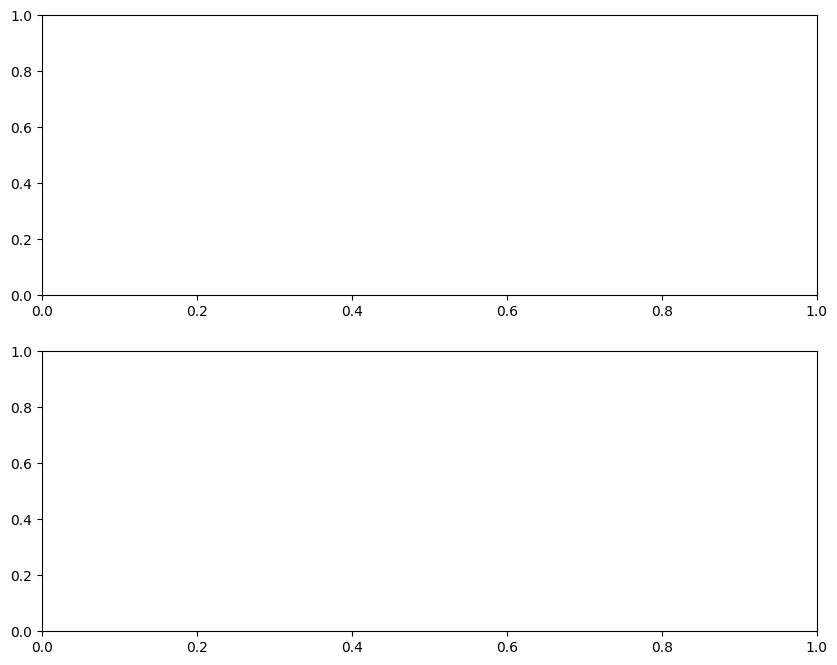

In [123]:
dataset_postprocessing = {
    "Total cells": [
            {"time": ehux_total_time, "values":  ehux_total_density},  # replicate 1
        ],
    "Dead cells": [
            {"time": ehux_dead_time, "values": ehux_dead_density},  # replicate 1
        ]
    }

posterior_dynamics3(
    dataset_postprocessing,
    trace=trace,
    model=model,
    n_plots=1,
    burn_in=50,
    num_variables=2,
    ode_fn=logistic_growth_death,
    ode2data_fn=ode_solution2data,
    save_path="../figures/vardi_growth_death_dynamics.png",
    var_properties=None,
    figsize=(10, 4),
    fontname='DejaVu Sans',
    fontsize=12,
    line_width=2,
    alpha=0.8,
    show=True,
    sharex=False,
    sharey=False,
    suptitle=None
)



In [117]:
def ode_solution2data(solution):
    """
    User-defined function to extract and compute useful outputs from the ODE solution.
    
    Args:
        solution (np.ndarray): shape (time_points, num_variables)

    Returns:
        dict: keys are output variable names, values are 1D arrays over time
    """
    live = solution[:, 0]
    dead = solution[:, 1]
    total = live + dead
    #return total, dead
    return {
        "total": total,
        "dead": dead
    }

In [101]:
sol_outputs

NameError: name 'sol_outputs' is not defined

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pymc as pm

def posterior_dynamics4(
    dataset,
    trace,
    model,
    num_variables,
    n_plots=100,
    burn_in=0,
    ode_fn=None,
    ode2data_fn=None,
    save_path=None,
    var_properties=None,
    figsize=(10, 4),
    fontname='DejaVu Sans',
    fontsize=12,
    line_width=2,
    alpha=0.8,
    show=True,
    sharex=False,
    sharey=False,
    suptitle=None,
    verbose=False
):
    """
    Plot dynamics for each variable with replicates and posterior predictive ODE trajectories.

    Parameters:
        dataset: dict of {variable name: list of dicts with 'time' and 'values'}
        trace: PyMC InferenceData object
        model: PyMC Model object (used to extract free_RVs)
        num_variables: number of ODE state variables
        n_plots: number of posterior samples to use
        burn_in: number of burn-in samples to skip
        ode_fn: function (y, t, params) -> dydt
        ode2data_fn: function (solution) -> dict of derived outputs
        save_path: if provided, path to save figure
        var_properties: dict of customization per variable
        figsize: size per subplot
        show: whether to show the plot
        suptitle: figure-wide title
        verbose: whether to print debug info
    """

    # Safety checks
    if trace is None or model is None:
        raise ValueError("Trace and model must be provided.")
    if dataset is None or not isinstance(dataset, dict):
        raise ValueError("Dataset must be a dict of {var_name: list of replicates}")
    if ode_fn is None or ode2data_fn is None:
        raise ValueError("ODE function and output extractor must be provided.")

    n_chains = trace.posterior.sizes["chain"]
    n_draws_per_chain = trace.posterior.sizes["draw"]
    total_samples = n_chains * n_draws_per_chain

    if burn_in >= total_samples:
        raise ValueError("Burn-in exceeds total number of samples.")
    if n_plots > (total_samples - burn_in):
        raise ValueError("n_plots exceeds available post-burn-in samples.")

    # Get posterior samples as stacked draws
    posterior_samples = trace.posterior.stack(draws=("chain", "draw"))
    var_names = [v.name for v in model.free_RVs]

    # Assume 1D parameter arrays (exclude multi-dimensional parameters)
    param_matrix = np.vstack([
        posterior_samples[v].values
        for v in var_names
        if v in posterior_samples and posterior_samples[v].values.ndim == 1
    ]).T

    # Plotting setup
    n_vars = len(dataset)
    fig, axes = plt.subplots(n_vars, 1, figsize=(figsize[0], figsize[1]*n_vars), sharex=sharex, sharey=sharey)
    if n_vars == 1:
        axes = [axes]

    # Get common time range across replicates
    all_times = [t for data in dataset.values() for rep in data for t in rep['time']]
    t_min, t_max = min(all_times), max(all_times)
    time_finer = np.linspace(t_min, t_max, 200)

    for ax, (var_name, replicates) in zip(axes, dataset.items()):
        props = var_properties.get(var_name, {}) if var_properties else {}
        label = props.get("label", var_name)
        color = props.get("color", None)
        ylabel = props.get("ylabel", label)
        sol_key = props.get("sol_key", var_name.lower().replace(" ", "_"))

        # Posterior predictive ODE simulations
        for i in range(n_plots):
            theta = param_matrix[burn_in + i]

            y0 = theta[-num_variables*2:-num_variables]  # assume last 2*num_variables are [y0, bounds]
            ode_params = theta[:-num_variables*2]

            sol = odeint(ode_fn, y0, t=time_finer, args=(ode_params,), rtol=1e-6, atol=1e-6)
            sol_outputs = ode2data_fn(sol)

            if sol_key not in sol_outputs:
                raise KeyError(f"sol_key '{sol_key}' not found in ode2data_fn output.")

            ax.plot(time_finer, sol_outputs[sol_key], '-', color='gray', alpha=0.1)

        # Replicate data
        for i, rep in enumerate(replicates):
            time = rep["time"]
            values = rep["values"]
            rep_label = f"{label} (rep {i+1})" if len(replicates) > 1 else label
            ax.plot(time, values, label=rep_label, color=color, lw=line_width, alpha=alpha, 
                    marker='o', markersize=4, linestyle='None')

        ax.set_title(label, fontsize=fontsize, fontname=fontname)
        ax.set_ylabel(ylabel, fontsize=fontsize, fontname=fontname)
        ax.set_xlabel("Time", fontsize=fontsize, fontname=fontname)
        ax.tick_params(labelsize=fontsize)
        if len(replicates) > 1:
            ax.legend(fontsize=fontsize - 2)

    if suptitle:
        fig.suptitle(suptitle, fontsize=fontsize+2, fontname=fontname)
    fig.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    if show:
        plt.show()

    return fig, axes

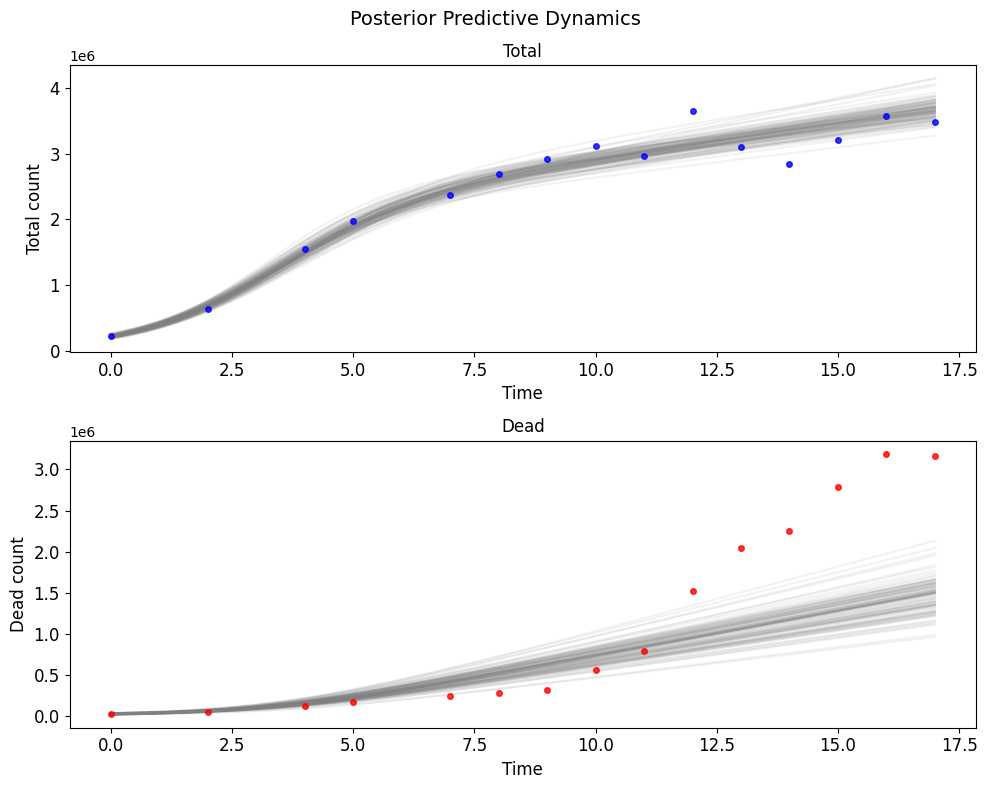

(<Figure size 1000x800 with 2 Axes>,
 array([<Axes: title={'center': 'Total'}, xlabel='Time', ylabel='Total count'>,
        <Axes: title={'center': 'Dead'}, xlabel='Time', ylabel='Dead count'>],
       dtype=object))

In [125]:
posterior_dynamics4(
    dataset=dataset_postprocessing,
    trace=trace,
    model=model,
    n_plots=100,
    burn_in=50,
    num_variables=2,
    ode_fn=logistic_growth_death,
    ode2data_fn=ode_solution2data,
    save_path="../figures/posterior_dynamics.png",
    var_properties={
        "Total cells": {"label": "Total", "color": "blue", "ylabel": "Total count", "sol_key": "total"},
        "Dead cells": {"label": "Dead", "color": "red", "ylabel": "Dead count", "sol_key": "dead"},
    },
    suptitle="Posterior Predictive Dynamics"
)